# Ejercicio Practico 1
## Data Understanding and Data Preparation
### 1. Analisis de Data Understanding

En esta primera parte vamos a tratar de mostrar cómo llevar a cabo un analisis de **Data Understanding** que nos permita conocer perfectamente los datos y nos permitirá obtener conclusiones que ayudarán a decidir el tratamiento que le vamos a dar a los datos en la siguiente parte.

El objetivo del analisis se ha explicado más arriba, pero el objetivo del proyecto en el que está enmarcado este analisis sería  estimar el precio de un vehículo de segunda mano a partir de datos concretos del vehículo y su estado.

En primer lugar vamos a importar las librerías de python que serán necesarias para realizar el analisis:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from sklearn.metrics import mutual_info_score
from scipy.stats import chi2_contingency
from itertools import combinations

#### 1.1 Analisis general del conjunto de datos

El siguiente paso es cargar nuestro dataset original que contiene los datos con los que vamos a trabajar. Vamos a hacer una primera inspección de los datos mostrando los 10 primeros registros. Para ello, por evitar que nos aparezcan valores nulos, ya que únicamente queremos ver que pinta tienen los datos (cuando hay datos...), le quitamos solo para esta instrucción los registros con más de 1 valor nulo.

In [2]:
# Cargar el dataset desde el archivo CSV
data = pd.read_csv('vehicles_red.csv')

# Configuración que permite mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Visualizar las primeras filas del dataset omitiendo las filas que tienen más de un NaN
data.dropna(thresh=data.shape[1] - 1).head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,lat,long,posting_date
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,NaN,al,31.425091,-85.617723,2021-04-12T11:20:35-0500
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,NaN,al,31.425091,-85.617723,2021-04-12T11:20:00-0500
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,NaN,al,31.425091,-85.617723,2021-04-12T11:19:58-0500
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,NaN,al,33.913500,-84.685900,2021-05-03T17:48:17-0500
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,NaN,al,33.353800,-86.825400,2021-05-03T16:03:27-0500


A la vista de los datos mostrados podemos comentar sobre las variables:
- **id**: número identificador del registro. Cada registro hace referencia a un vehículo y su id es único en todo el dataset
- **region**: región estadounidense donde se vende el vehículo
- **price**: precio de venta (nuestra variable objetivo)
- **year**: año en que se fabricó el vehículo
- **manufacturer**: fabricante
- **model**: modelo
- **condition**: estado en el que se encuentra el vehículo
- **cylinders**: número de cilindros del motor
- **fuel**: tipo de combustible que utiliza
- **odometer**: kilometraje del vehículo desde su fabricación
- **title_status**: estado legal del vehículo
- **transmission**: tipo de transmission que utiliza el coche
- **VIN**: numero de bastidor
- **drive**: tipo de tracción del vehículo
- **size**: tamaño
- **type**: tipo de carrocería
- **paint_color**: color de la pintura del vehículo
- **state**: estado de EEUU donde se vende el vehículo
- **lat**: coordenada de latitud GPS
- **long**: coordenada de longitud GPS
- **posting_date**: fecha y hora de subida del anuncio de venta en los últimos 30 días

Ahora procedemos a profundizar un poco más en el dataset viendo las dimensiones y alguna información adicional como los tipos de datos de cada columna.

In [3]:
# Realizar una descripción inicial del dataset
data.info()  # Información general de las columnas, tipos de datos y no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  county        0 non-null       float64
 18  stat

Tenemos un total de 22 variables (incluyendo la variable objetivo ***price***) y un volumen de 426.880 registros. Es un volumen considerable para poder hacer un buen analisis. En cuanto a los tipos de datos, vemos que casi todas las variables son categóricas (o al menos así las categoriza automaticamente python en base al tipo de datos) excepto...

- id
- price
- year
- odometer
- county
- lat
- long

...que son numéricas.

Ya de entrada vemos cosas interesantes de cara a la preparación de los datos, como que la variable ***county*** no tiene ni un solo valor que no sea nulo (NaN). Tambien vemos que nuestra variable objetivo es numérica y no le falta ni un solo valor. Otras variables como ***paint_color*** o incluso ***manufacturer*** tienen un volumen significativo de datos nulos que habrá que estudiar en su momento.

Para ser un poco más ágiles en los cálculos vamos a quitar del conjunto de datos alguna columna que, tras haber comprendido el contenido de cada una y por distintos motivos, hemos determinado que no aportan a nuestro proyecto. Aquí estamos aplicando nuestro criterio y, aunque esta es más una operación propia de la fase de Data Preparation, nos viene bien algún pequeño recorte en el dataset para aligerarlo y no dedicar recursos a algunas de ellas. Eliminamos por tanto:

- **county**: ya que no tiene ni un solo valor distinto de nulo
- **lat** y **long**: ya que ambas nos dan las coordenadas específicas del lugar de venta del vehículo, en realidad contamos ya con la región y el estado, y salvo que fueramos a hacer analisis geográfico muy avanzado, no parece que sea relevante. Además siempre se puede volver atras y recuperarla si fuera necesario.
- **id**: ya tenemos un índice o identificador de registro en nuestro dataframe de pandas, no nos aporta nada relevante para el proyecto. Es más información de base de datos que del vehículo en sí.
- **VIN**: el número de bastidor, tampoco nos aporta nada. Es el mismo caso que el anterior solo que en lugar de ser puramente de base de datos, es un identificador que la ley utiliza para registrar los vehículos. Además, la mitad de sus valores son nulos.
- **posting_date**: esta columna nos indica la fecha en que se ha publicado el anuncio en los últimos 30 días, no parece que tenga mucha relevancia para la variable objetivo por lo que la eliminaremos. Sin embargo la variable **year** si que tiene importancia puesto que nos indica la fecha de fabricación del vehículo y eso si que es relevante para el precio.



In [4]:
# Elimnar columnas irelevantes persistiendo el cambio en el dataframe original
data.drop(columns=['county','lat','long','id','VIN','posting_date'], inplace=True)

#### 1.2 Analisis de variables numéricas

Pasamos ahora a estudiar con más detalle las variables numéricas del dataset. Para ello sacamos unos estadisticos básicos que nos hablen a grandes rasgos de las distribuciones de valores de nuestras 3 variables númericas:

In [5]:
# Estadísticas descriptivas (media, std, min, max, etc.)
print(data.describe())

              price           year      odometer
count  4.268800e+05  425675.000000  4.224800e+05
mean   7.519903e+04    2011.235191  9.804333e+04
std    1.218228e+07       9.452120  2.138815e+05
min    0.000000e+00    1900.000000  0.000000e+00
25%    5.900000e+03    2008.000000  3.770400e+04
50%    1.395000e+04    2013.000000  8.554800e+04
75%    2.648575e+04    2017.000000  1.335425e+05
max    3.736929e+09    2022.000000  1.000000e+07


Tenemos ahora solo 3 variables a estudiar númericas. Todas ellas muestran cosas interesantes:

- **price**: de los estadísticos podemos ver que todos los registros tienen valores. La media de los precios se sitúa en 75.199`$` lo que parece un valor muy distinto al valor de su mediana (percentil 50) que se sitúa en los 13.950`$`. Esta diferencia puede derivarse de una asimetría importante en la distribución y/o presencia de outliers. Viendo que el 75 percentil todavía se encuentra por debajo de la media en 26.485`$` y que el valor máximo se encuentra en un precio desorbitado de 3.736.929.000`$`, claramente la presencia de outliers está afectando a ciertos estadísticos como la media y la desviación estandar que está en 12.182.270`$`. Habrá que estudiar muy bien los outliers y valores erroneos de esta variable.
- **year**: el año muestra estadisticos más normales en general aunque con ciertas incertidumbres. Si bien es cierto que parece que hay algún valor nulo, parece que son muy poquitos. Por otro lado vemos que en media los coches se fabricaron en 2011, muy cerquita de su mediana en 2013. El valor máximo es 2022 que parece un valor razonable y que será la fecha hasta la que se han tomado datos en este conjunto. Sin emabargo, el valor mínimo de 1900, habrá que ver si valores tan atrás en el tiempo tienen o no sentido y en su caso, qué hacer con ellos.
- **odometer**: esta variable muestra también problemas asociados a outliers o valores erroneos. En este caso, viendo el kilometraje máximo, parecen poco razonables valores como 10.000.000km. Claramente es un error.

Mas allá de estos detalles que analizaremos en profundidad más adelante, veamos ahora que pinta tienen gráficamente las distribuciones de estas variables mediante histogramas.

Vamos a crear una variable que registra las variables numéricas que tenemos. Esto nos será útil cuando queramos iterar sobre ellas en varias ocasiones.

Variables numéricas:  ['price' 'year' 'odometer']


c:\program files\python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\program files\python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


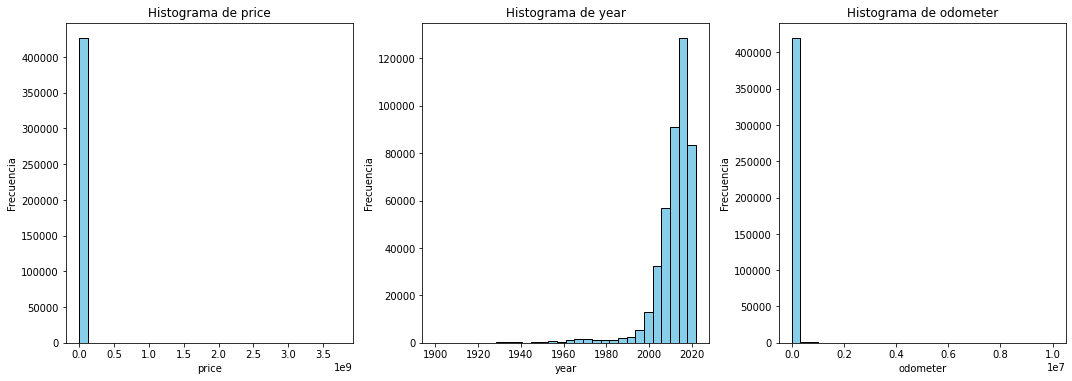

In [6]:
# Identificar las columnas numéricas
numeric_columns = data.select_dtypes(include=[np.number]).columns
print("Variables numéricas: ", numeric_columns.values)

# Crear una figura con subplots
num_vars = len(numeric_columns)
fig, axes = plt.subplots(nrows=(num_vars // 3) + 1, ncols=3, figsize=(15, 5 * ((num_vars // 3) + 1)))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Graficar el histograma
    axes[i].hist(data[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Eliminar ejes sobrantes si hay menos de 3 variables
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Pintar histogramas no es fácil cuando tienes unos outliers que se van varios ordenes de magnitud por encima de los valores normales del conjunto. Esto es lo que sucede con ***price*** y con ***odometer***. La variable ***year*** si que podemos ver más o menos bien la distribución que tienen los datos. Se trata de una distribución claramente asimetrica que crece exponencialmente a partir de los años 90'. Alcanza su máximo en torno al año 2015.

Para poder visualizar la parte más baja de la distribución de las otras 2 variables, vamos a volver a calcular los histogramas, pero omitiendo todos los valores por encima del 95 percentil. Es una forma de hacer zoom a la distribución de la zona más a la izquierda. Para ello definimos una función a la que le pasamos el dataframe y un percentil (en este caso el 95) y generará los histogramas omitiendo el 5% más alto.

Percentil 95 de price: 44500.0
Percentil 95 de year: 2020.0
Percentil 95 de odometer: 204000.0


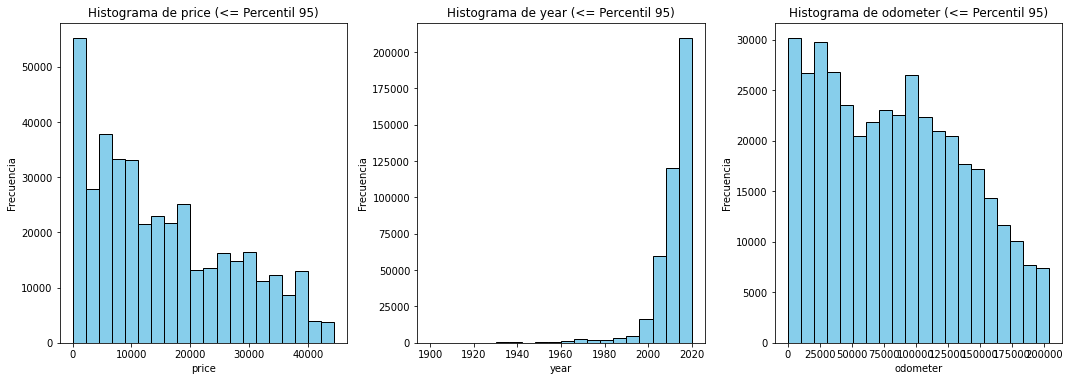

In [7]:
# Crear una función para graficar histogramas hasta el percentil X
def plot_histograms_percentile(df, x):
  
    # Crear una figura con subplots
    num_vars = len(numeric_columns)
    fig, axes = plt.subplots(nrows=(num_vars // 3) + 1, ncols=3, figsize=(15, 5 * ((num_vars // 3) + 1)))
    axes = axes.flatten()
    
    for i, col in enumerate(numeric_columns):
        # Calcular el percentil 95 de la variable
        percent = np.percentile(df[col].dropna(), x)
        print(f"Percentil 95 de {col}: {percent}")
        
        # Filtrar los valores hasta el percentil 95
        filtered_data = df[col][df[col] <= percent]
        
        # Graficar el histograma
        axes[i].hist(filtered_data, bins=20, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Histograma de {col} (<= Percentil 95)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')
    
    # Eliminar ejes sobrantes si hay menos de 3 variables
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_histograms_percentile(data,95)

Llama la atención que la barrita donde se encuentra el valor 0 tanto en el histograma de ***price*** como el de ***odometer***, en ambos casos es la más alta. En el caso del kilometraje puede tener sentido ya que al final es bastante habitual la venta de coches de km0 o casi nuevos. Pero llama más la atención en el precio. Si bien es cierto que hay coches que se venden por piezas y que por tanto lo que queda de ellos puede ser residual, de pocos cientos de dolares, pero grátis... habrá que ver si es normal o si lo tratamos como valores erroneos o no.

En el caso del histograma de ***year***, no es válido ni aporta mucha información ya que no había outliers y por tanto lo único que hemos hecho ha sido quitar un 5% de datos que se encuentran entre el año 2020 y el año 2022.

Vamos a contabilizar los valores estrictamente 0 de estas variables. Para ello definimos una función que nos lo calcula:

In [8]:
# Función para contar los ceros en cada columna numérica
def count_zeros(df):
    
    # Contar ceros en cada columna numérica
    zero_counts = df[numeric_columns].apply(lambda x: (x == 0).sum())
    
    return zero_counts

for i, col in enumerate(numeric_columns):
    # Llamar a la función para contar ceros
    zero_counts = count_zeros(data)
    print(f"Numero de 0s en {col}: {zero_counts[col]}")

Numero de 0s en price: 32895
Numero de 0s en year: 0
Numero de 0s en odometer: 1965


Se ve que hay un alto número de registros de vehículos vendidos a un precio de 0`$`. Pocos pero algunos registros hay también de vehículos con 0km.

Pasamos ahora a analizar la relación existente entre las 3 variables numéricas. Para ello vamos a calcular una matriz de correlaciones donde podamos ver para cada par, su correlación. Definimos una función para que nos muestre la matriz en base a un dataframe que pasemos como input y un percentil por si queremos evitar el problema de los outliers omitiendolos de la matriz. Además, vamos a omitir en la función también los valores NaN que pueda haber en las columnas de forma que solo trabajemos con el cojunto de registros que tengan valores en los 3 campos.

Calcularemos 2 matrices, una con todos los datos sin quitar outlier y otra omitiendo el 2% de valores más altos

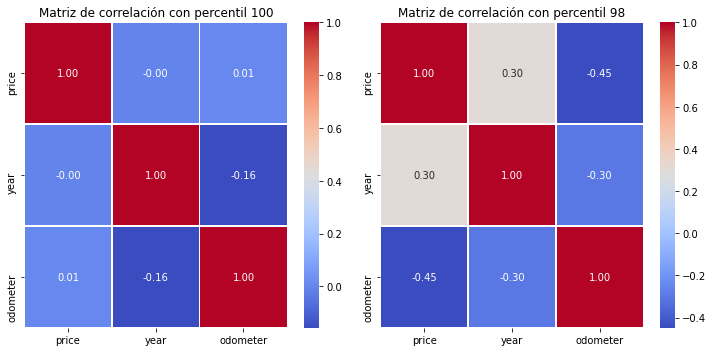

In [9]:
# Función para crear la matriz de correlación entre las variables numéricas
def corr_matrix_percent(df, x):
    # quitamos del dataframe todos los registros con valores nulos (NaN) en alguna de las columnas numericas
    filtered_data = df[numeric_columns].dropna()
    
    for i, col in enumerate(numeric_columns):
        # Calcular el percentil x de la variable
        percent = np.percentile(filtered_data[col], x)

        # Filtrar los valores hasta el percentil x
        filtered_data = filtered_data[filtered_data[col] <= percent]

    # Correlación entre variables numéricas
    correlation_matrix = filtered_data.corr()
    return correlation_matrix

percentiles = [100,98]

fig, axes = plt.subplots(nrows=(len(percentiles) // 3) + 1, ncols=3, figsize=(15, 5 * ((len(percentiles) // 3) + 1)))
axes = axes.flatten()

for i, percentil in enumerate(percentiles):
    corr_matrix = corr_matrix_percent(data,percentil)
    
    # Graficar matriz
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, ax=axes[i])
    axes[i].set_title(f'Matriz de correlación con percentil {percentil}')
    
# Eliminar ejes sobrantes si hay menos de 3 variables
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

En la matriz de la izquierda se ve que no existe correlación entre ninguna de las 3 variables. Todos los coeficientes están practicamente en 0. Sin embargo, al reducir el percentil al 98 omitiendo los outliers, se puede apreciar cierta relación entre las 3 variables. Especialmente interesante la relación entre la variable objetivo ***price*** y las otras 2. 

Con ***year*** hay una correlación de 0.30 que se podría decir que es suficientemente significativa como para indicar que se trata de una variable relevante. Tiene su sentido, cuanto más antiguo sea el coche, en muchos casos es normal que su precio descienda. La relación no es muy fuerte ya que hay otras razones que influyen en el precio. 

Por otro lado, la relación con el kilometraje (***odometer***) es incluso más fuerte siendo de -0.45. El hecho de que el coeficiente sea negativo nos indica que la relación es inversa, cosa que tiene sentido: cuantos más km tenga el coche, más deteriorado por el uso y por tanto su precio baja.


#### 1.3 Analisis de variables categóricas

Ahora vamos a pasar a estudiar las variables categóricas. Empezaremos analizando la cardinalidad de dichas variables, es decir, vamos a ver cuantas categorías tiene cada variable categórica.

In [10]:
# Identificar las variables categóricas
category_columns = data.select_dtypes(include=['object', 'category']).columns
print("Variables categóricas: ", category_columns.values)

# Calcular la cardinalidad de cada columna
cardinalities = data[category_columns].nunique()
print('\n',cardinalities.sort_values(ascending=False))

Variables categóricas:  ['region' 'manufacturer' 'model' 'condition' 'cylinders' 'fuel'
 'title_status' 'transmission' 'drive' 'size' 'type' 'paint_color' 'state']

 model           29667
region            404
state              51
manufacturer       42
type               13
paint_color        12
cylinders           8
condition           6
title_status        6
fuel                5
size                4
transmission        3
drive               3
dtype: int64


Analizamos el listado devuelto con las cardinalidades. Lo primero que llama la atención es la cardinalidad de la variable ***posting_date*** que, con una cardinalidad de 381.536 lidera la lista. Al tratarse de una variable temporal que nos indica el instante en que se publicó el anuncio de un vehículo, la cardinalidad es altisima porque es prácticamente una variable continua. en este caso no merece la pena tratarla tal cual está como una variable categórica, ya que los resultados y los recursos de computación que demanda tratarla sin transformarla, sería ineficiente y podría inducir a errores. Más adelante, transformaremos esta variable dandole un formato más adecuado, más sencillo y más tratable. Por el momento la omitimos.

La siguiente en la lista es una variable que es puramente categórica por definición, ***model***. Esta variable, al indicar el modelo, por muchos que haya, no dejan de ser categorías. Es cierto que el volumen de categorías que tiene es tán elevado, que en muchos casos aportará poco. Si dividimos el total de registros entre las categorías que tiene esta variable, nos sale un promedio de 14 registros por categoría. Es muy pequeña la representatividad de una categoría con solo 14 registros. Por tanto en primera instancia, vamos a omitirla por el momento, y si lo consideramos necesario, volveremos sobre ella para incorporarla. Además, al ocntar con la variable ***manufacturer***, que sería una forma de agrupación en menos categorías de esa variable, podemos arrancar el analisis.

Algo parecido ocurre con la variable ***region*** y ***state***. La primera detalla mucho más la segunda al hablarnos de regiones dentro de los distintos estados de EEUU. De nuevo, si concluyeramos que puede aportar valor la componente geográfica que aporta la región en este caso, la volveríamos a incorporar más adelante.

Vamos a trabajar por tanto con aquellas variables categóricas que tienen menos de 60 categorías en un primer paso. Lo primero que vamos a hacer es analizar las frecuencias de las categorías de cada variable. Para ello preparamos una tabla como la siguiente:

In [11]:
# Identificar las variables categóricas con menos de 60 categorías
categorical_cols_reduced = cardinalities[cardinalities < 60].index
print("Variables categóricas: ", categorical_cols_reduced.values)

for column in categorical_cols_reduced:
    print(f"\nFrecuencia de la columna {column}:")
    print(data[column].value_counts())

Variables categóricas:  ['manufacturer' 'condition' 'cylinders' 'fuel' 'title_status'
 'transmission' 'drive' 'size' 'type' 'paint_color' 'state']

Frecuencia de la columna manufacturer:
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn       

Salvo para la variable ***manufacturer*** que hay 5 o 6 categorías que tienen menos de 100 registros, el resto de categorías de todas las variables, tienen más de 200 registros y por tanto se puede decir que están en mayor o menor medida, representadas en el dataset. Si bien es cierto que lo deseable sería que hubiera como mínimo 1000 registros por cada categoría. Esto, si supusiera un problema dada la relevancia de esta variable, se podría aplicar una **recategorización de las categorías minoritarias agrupandolas en una única categoría** que las englobe a todas ellas. Lo malo es que se pierde toda la información específica de esas categorías. Por el momento las dejaremos como están e iremos viendo la necesidad de trasnformarlas.

A conitnuación, lo primero que vamos a hacer es analizar la relación que tienen entre todas ellas mediante el coeficiente V de Cramer. Este coeficiente es el equivalente a la correlación pero en este caso para variables categóricas.

Creamos una función que calcula el coeficiente a partir de una tabla de contigencia que le pasamos como argumento. Después construimos una matriz de V de Cramer exactamente igual que la de correlación pero con este otro estadístico. Así podremos ver todas las relaciones entre pares de variables y cuales son más independientes entre sí.

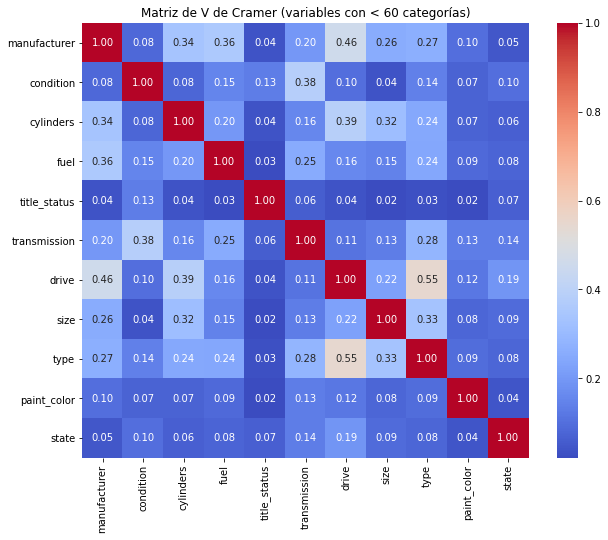

In [12]:
# Función para calcular V de Cramér
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()  # Número total de observaciones
    k = min(confusion_matrix.shape)  # Número de categorías en la variable
    return np.sqrt(chi2 / (n * (k - 1)))

# Crear una matriz vacía para almacenar los valores de V de Cramer
matrix = pd.DataFrame(index=categorical_cols_reduced, columns=categorical_cols_reduced)

# Calcular V de Cramer para cada par de variables categóricas
for var1, var2 in combinations(categorical_cols_reduced, 2):
    contingency_table = pd.crosstab(data[var1], data[var2])
    value = cramers_v(contingency_table)
    matrix.loc[var1, var2] = value
    matrix.loc[var2, var1] = value

# Llenar la diagonal con 1s
np.fill_diagonal(matrix.values, 1)

# Convertir a tipo float
matrix = matrix.astype(float)

# Visualizar la matriz como heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de V de Cramer (variables con < 60 categorías)")
plt.show()

En general se ve que no hay pares de variables categorícas que estén tan relacionadas que alguna sea incluso descartable. Es cierto que hay relación entre alguna de ellas, por ejemplo, entre el tipo de tracción ***drive*** y el tipo de carrocería ***type***, el factor V de Cramer es de 0.55 que no es bajo. Es normal que haya cierta relación ya que por ejemplo los 4x4 deben tener una carrocería especifica.

Otros valores son algo más bajos pero también significativos, como por ejemplo el tipo de tracción ***drive*** con el fabricante ***manufacturer***, con un factor de 0.46, se muestra cierta relación. También tiene cierto sentido, puesto que algunos fabricantes se centran más en un tipo de tracción en gran parte de sus vehículos.

Pero en lineas generales, no hay mucha relación entre ellas y esto aporta más información que podría ser relevante para luego poder predecir la variable objetivo.

Vamos a pasar ahora a intentar analizar gráficamente la relación entre la variable objetivo y las categóricas. Para ello vamos a pintar unos diagramas tipo boxplot para mostrar, para cada categoría de cada variable, la distribución de la variable objetivo ***price***. Eso si, nos vamos a quedar con el 98 percentil de la objetivo para evitar que los outliers nos den guerra como lo hizo en las correlaciones con las numéricas.

56900.0


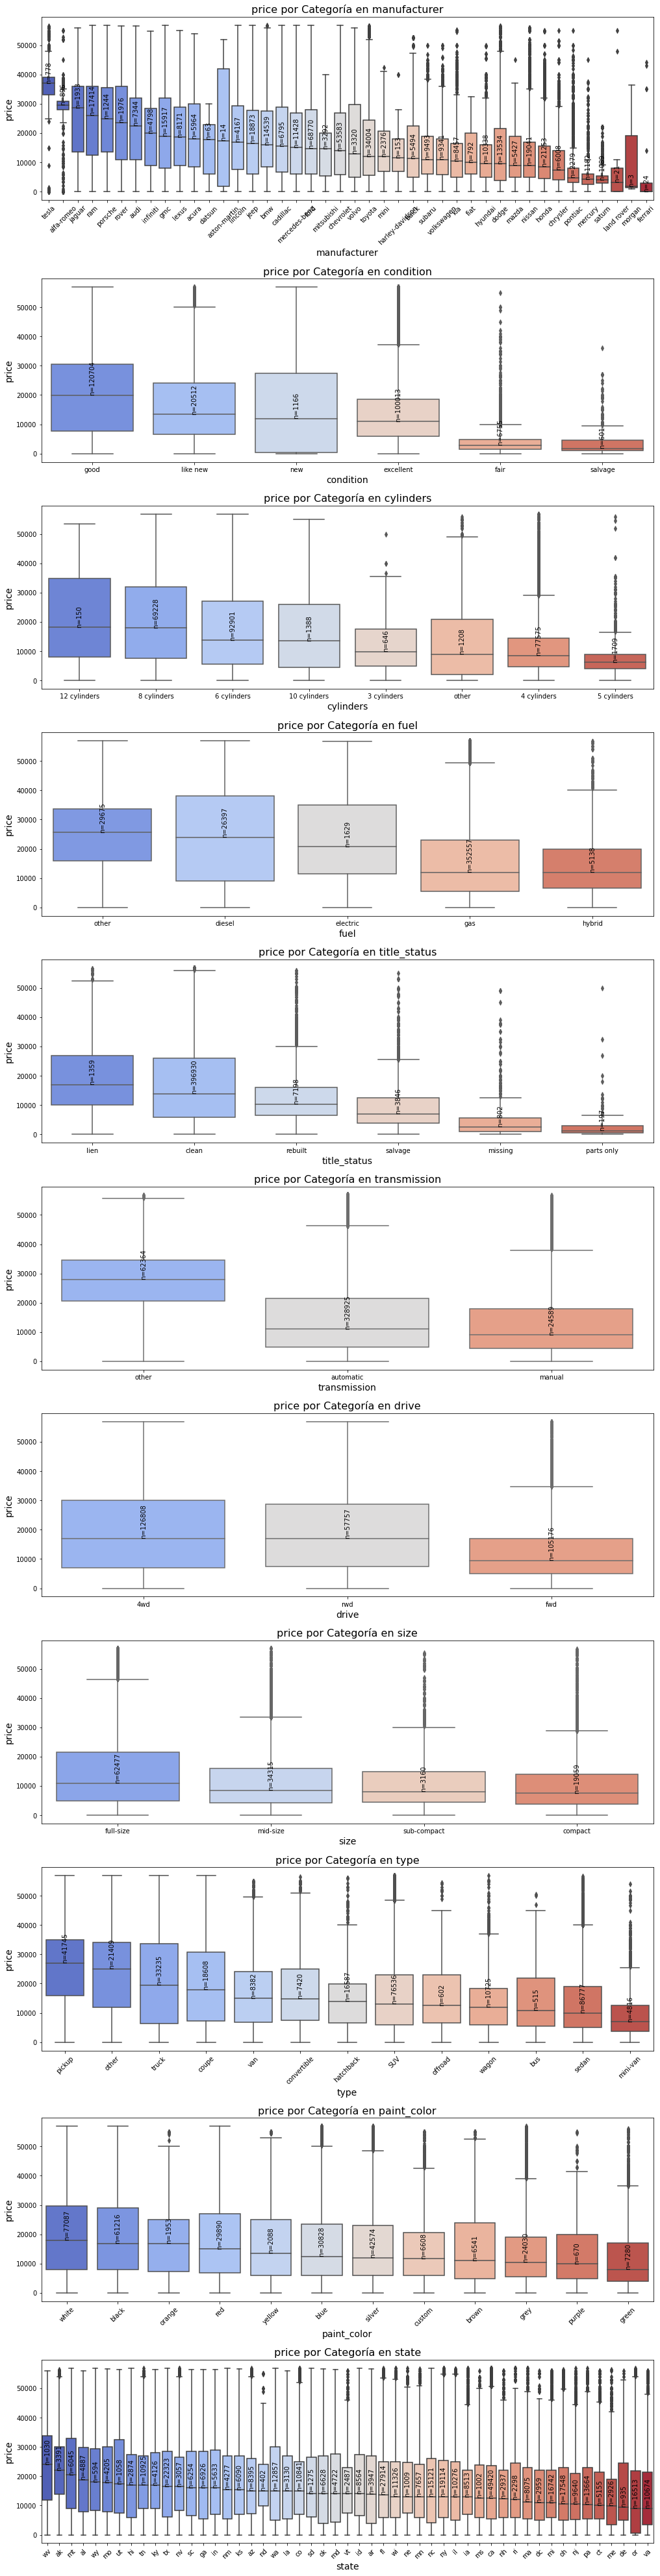

In [13]:
target_var = 'price'
percentil = 98

# Calcular el percentil 98 de la variable
percent = np.percentile(data[target_var].dropna(), percentil)
print(percent)

# Filtrar los valores hasta el percentil 98
filtered_data = data[data[target_var] <= percent]

# Crear el grid de subplots
n_cats = len(categorical_cols_reduced)
fig, axes = plt.subplots(n_cats, 1, figsize=(14, 5 * n_cats), constrained_layout=True)

# Generar un boxplot por cada variable categórica
for ax, cat in zip(axes, categorical_cols_reduced):
    # Ordenar las categorías según la mediana calculada
    medians = filtered_data.groupby(cat)[target_var].median().sort_values(ascending=False)
    ordered_categories = medians.index
    
    # Generar el boxplot con las categorías ordenadas
    sns.boxplot(x=cat, y=target_var, data=filtered_data, order=ordered_categories, palette='coolwarm', ax=ax)
    ax.set_title(f'{target_var} por Categoría en {cat}', fontsize=16)
    ax.set_xlabel(cat, fontsize=14)
    ax.set_ylabel(target_var, fontsize=14)
    
    # Añadir las etiquetas con el número de registros
    for i, category in enumerate(ordered_categories):
        # Filtrar los datos de la categoría actual
        category_data = filtered_data[filtered_data[cat] == category][target_var]
        num_records = len(category_data)
        
        # Calcular la mediana de la categoría
        median_value = category_data.median()

        # Verificar que la mediana es un valor finito y añadir la etiqueta
        if np.isfinite(median_value):
            # Colocar la etiqueta con el número de registros encima de la mediana
            ax.text(
                i, median_value,  # i es la posición en el eje x
                f'n={num_records}', 
                ha='center', va='bottom', fontsize=10, color='black', rotation=90  # Girar etiqueta 90 grados
            )
    
    # Condición para rotar etiquetas si hay más de 10 categorías
    num_categories = filtered_data[cat].nunique()
    if num_categories > 10:
        ax.tick_params(axis='x', labelrotation=45)  # Rotar etiquetas en 45 grados
    else:
        ax.tick_params(axis='x', labelrotation=0)  # Dejar etiquetas horizontales

# Mostrar el grid de boxplots
plt.show()



En variables categóricas, salvo que la relación con la variable objetivo sea muy fuerte, no es sencillo detectar patrones de relación. Al ver estos gráficos boxplot en la mayoría podemos ver que algun tipo de relación puede existir pero tampoco somos capaces de interpretarlo con excesiva claridad.

Hay casos como por ejemplo en la variable ***condition*** donde se ve una clara relación entre el ***price*** y la ***condition*** a través de algunas de sus categorías. Por ejemplo las categorías de *salvage* y *fair* son las que presentan un precio más bajo en los vehículos, especialmente la de *salvage*. Esto tiene su sentido puesto que si el estado del coche es para desguace, su valor, tiene que ser mucho más bajo que esos mismos vehçiculos en otras condiciones. Lo mismo ocurre con *fair* donde el vehículo aun puede funcionar si se le hace algún tipo de reparación mecánica. Sin embargo, el resto de categorías, ya no se aprecia tan clara la diferencia entre ellos y seguramente se deba a otros muchos criterios y variables que están entrando en juego y afectando a esta relación.

Otro ejemplo de relación visible entre la categórica y la objetivo a través de estos diagramas sería la variable ***title_status***, donde se puede apreciar claramente que el precio de los vehículos vendidos como *parts only* son los que presentan un precio más bajo ya que se venden por partes. Después vendrían aquellos con título *missing* que son los que legalmente tienen algún problema por haber sido robados o cualquier otra situación. Luego vendrían los que han sido declarados como no aptos para circular por ser siniestro (*salvage*), *reconstruidos*, luego vendrían los *clean* y por último los *lien* que son los que aún tienen una deuda pendiente de pago que hay que saldar. Esta variable si que podría aportar información relavante para el modelo. No significa que las otras no, pero esta es clara incluso a simple vista.

Cuando nos vamos a otras variables como ***drive***, encontramos categorías como *fwd* que tienen un precio mucho más bajo que las otras por ser el tipo de tracción seguramente más extendido entre los fabricantes. Pero luego si miramos en detalle los boxplot de las otras 2 categorías *4wd* y *rwd* se ve que los diagramas son prácticamente iguales y ambos con un volumen de registros muy alto y por tanto representativo. Esto significa que, en terminos de ***price***, no hay ninguna relación. A todos los efectos es como si fueran la misma categoría.

Al analizar la variable ***size***, podemos ver de primeras que los diagramas son casi todos iguales. Es cierto que parece que la categoría de *full-size* tiene algunos valores por encima de la media, pero tanto la mediana como los valores inferiores están distribuidos exactamente igual que las otras categorías respecto al ***price***. Esto nos hace sospechar de que no parece haber una clara relación con nuestra variable objetivo. Si a eso le sumamos que el número de muestras en cada grupo es representativo, pero al sumarlas todas vemos que no se acercan ni al 30% del total de los registros, da que pensar que esta variable no aporta practicamente información. Se tomará la decisión final en el próximo apartado.

El resto, hay un poco de todo, en algunas se puede intuir alguna relación pero no somos capaces de interpretarla de forma clara, y en otras puede que las haya o no pero no somos capaces de verla. Tampoco podemos asegurar que no haya relación como en este último ejemplo comentado ya que los diagramas difieren en cierto modo.


#### 1.4 Analisis de valores nulos

Vamos a pasar a analizar los missing values o valores nulos. Para ello tomamos el dataset completo de nuevo con las variables numéricas y categóricas.

In [14]:
# Análisis de Missing Values
missing_data = data.isnull().sum()
missing_data_percentage = (missing_data / len(data)) * 100

# Crear un dataframe con ambas columnas
missing_summary = pd.DataFrame({'Missing Values': missing_data,'Percentage': missing_data_percentage})

# Mostrar resultados
print("\nPorcentaje de valores faltantes por columna:")
missing_summary.sort_values(by='Percentage', ascending=False)


Porcentaje de valores faltantes por columna:


,Missing Values,Percentage
size,306361,71.767476
cylinders,177678,41.622470
condition,174104,40.785232
drive,130567,30.586347
paint_color,130203,30.501078
type,92858,21.752717
manufacturer,17646,4.133714
title_status,8242,1.930753
model,5277,1.236179
odometer,4400,1.030735


Tal como esperabamos, la variable ***size*** tiene un porcentaje de valores nulos superior al 70%. Esta variable encima no tiene prácticamente relación entre sus categorías y la variable objetivo, es decir, que su variabilidad no explica practicamente nada de la variabilidad de nuestra variable objetivo. Por otro lado, cuando estudiamos mediante la V de Cramer las relaciones con otras variables, vimos que tampoco había una clara relación fuerte entre esta variable y alguna otra que nos pueda ayudar a rellenar los huecos que faltan con valores con un cierto sentido. **Es por ello que esta variable tiene sentido eliminarla del dataset.**

Seguimos analizando y a continuación tenemos la variable ***cylinders*** y la variable ***condition***. Ambas tienen un alto volumen de valores faltantes. Si bien es cierto que, especialmente la variable ***condition***, se vio que tenía cierta relación con la variable objetivo, sería una pena desecharla. En ambos casos además vemos que hay cierta relación (no muy fuerte) con otras variables según la V de Cramer. Por ejemplo ***condition*** con ***transmission*** tiene una V de Cramer de 0.38 y ***cylinders*** con ***drive*** de 0.39. En este caso, la variable ***drive*** tiene un volumen muy alto de valores faltantes, por lo que complica un poco la imputación de valores faltantes en ***cylinders***, pero en el caso de ***transmission***, no le falta prácticamente ningún valor y por ello, se podría utilizar para rellenar huecos de la variable ***condition***.

Por otro lado, ***drive*** si que tiene variables con las que tiene más relación. Por ejemplo con ***manufacturer*** tiene una V de Cramer de 0.46 y con ***type*** de 0.55. No son despreciables y podría tener sentido utilizarlas para rellenar los vacíos de ésta.

La variable ***type*** tampoco se queda atrás en volumen de registros vacíos, por lo que deberíamos tratar de plantear una estrategía con ella. Es una variable que puede aportar cierta información relevante.

A partir de aquí, las demás variables presentan menos de un 5% de datos faltantes. En estos casos, estrategias como la eliminación de los registros pueden ser útiles. Especialmente si vemos que justo los registros a los que les faltan datos en estas variables son comunes entre ellos y por tanto desechar registros con un alto volumen de vacíos por registro, no tiene impacto para el modelo y sin embargo nos limpia los datos de vacios.

Para ello vamos a mostrar una tabla donde en un campo se indique el número de variables que para un registro vienen vacías o con NaN, la combinación de variables con NaN y una última columna que nos muestre la cuenta de registros de cada tipología. Esto nos ayudará mucho a tomar decisiones sobre la eliminación de registros y/o variables.

In [15]:
# Contar valores null por fila quitando la variable size
null_counts = data.drop(columns=['size'], inplace=False).isnull().sum(axis=1)

# Crear la tabla resumen
summary = null_counts.value_counts().reset_index()
summary.columns = ['num_nulls', 'count']
summary = summary.sort_values('num_nulls').reset_index(drop=True)

# Aplicar estilo con pandas Styler par mostrar en rojo num_nulls >= 6
def highlight_rows(s):
    color = 'background-color: red; color: white;' if s['num_nulls'] >= 6 else ''
    return [color] * len(s)

summary_styled = summary.style.apply(highlight_rows, axis=1)

# Mostrar resultado estilizado
summary_styled


,num_nulls,count
0,0,115988
1,1,108473
2,2,86712
3,3,49685
4,4,21169
5,5,39385
6,6,4695
7,7,17
8,8,125
9,9,539


A la vista de los números que salen, tiene sentido eliminar todos aquellos registros que tengan 6 o más variables vacías. No es un volumen de registros muy alto, supone aproximadamente el 1% de los datos y además pierden la información de como minimo 6 variables.

Recalculamos la tabla que contabiliza los nulos habiendo desechado estos nulos en rojo, y la variable ***size***, para ver cómo quedaría la situación si lo hicieramos:

In [16]:
# Análisis de Missing Values
df = data.drop(columns=['size'], inplace=False)
df = df.dropna(thresh=df.shape[1] - 5)
missing_data = df.isnull().sum()
missing_data_percentage = (missing_data / len(data)) * 100

# Crear un dataframe con ambas columnas
missing_summary = pd.DataFrame({'Missing Values': missing_data,'Percentage': missing_data_percentage})

# Mostrar resultados
print("\nPorcentaje de valores faltantes por columna:")
missing_summary.sort_values(by='Percentage', ascending=False)


Porcentaje de valores faltantes por columna:


,Missing Values,Percentage
cylinders,172272,40.356072
condition,168651,39.507824
drive,125108,29.307534
paint_color,124815,29.238896
type,87512,20.500375
manufacturer,14226,3.332552
title_status,7397,1.732805
model,3891,0.911497
odometer,3643,0.853401
fuel,2158,0.505528


A continuación vamos a profundizar en los nulos de la variable ***condition***. Esta variable ya hemos visto que muestra cierta relación con la variable objetivo a través de los boxplot. Vamos a hacer una comparativa para entender si los valores faltantes de esta variable tienen algun patrón relevante con la variable objetivo. Esto nos ayudaría con la decisión final sobre esta variable.

Mostramos 2 diagramas boxplot. En uno pintamos la distribución de ***price*** para el 98 percentil del conjunto de datos completo. Usamos el 98 percentil para que eliminar los outliers nos permita ver bien las distribuciones. En el otro diagrama pintamos lo mismo pero reduciendo aún más el conjunto quedandonos únicamente con los registros con valores nulos de ***condition***.

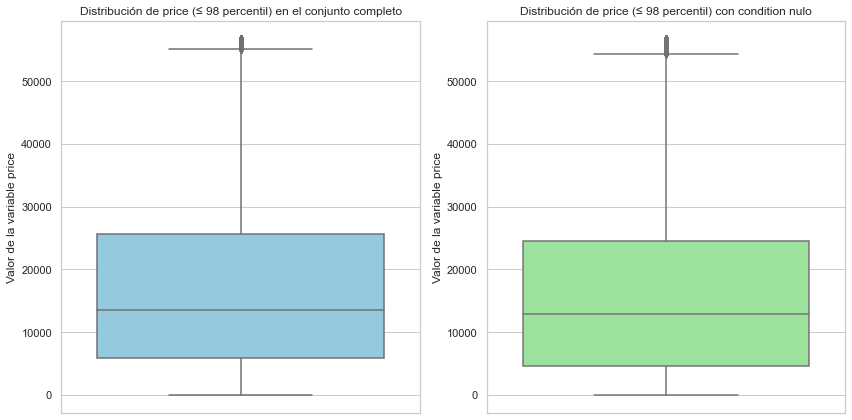

In [17]:
# Configuración para gráficos
sns.set(style="whitegrid")  # Estilo de gráficos

# Calcular el percentil de la variable objetivo 'price'
p = 98
percentile = df['price'].quantile(p/100)

# Filtrar los datos: registros donde 'price' <= percentil
df_percentile = df[df['price'] <= percentile]

# Filtrar datos donde 'condition' es nulo y 'price' <= percentil
df_null_X = df_percentile[df_percentile['condition'].isnull()]

# Crear los boxplots
plt.figure(figsize=(12, 6))  # Tamaño del gráfico

# Primer Boxplot: Todo el conjunto de datos
plt.subplot(1, 2, 1)
sns.boxplot(y='price', data=df_percentile, color="skyblue")
plt.title(f"Distribución de price (≤ {p} percentil) en el conjunto completo")
plt.ylabel("Valor de la variable price")

# Segundo Boxplot: Registros donde condition es nulo
plt.subplot(1, 2, 2)
sns.boxplot(y='price', data=df_null_X, color="lightgreen")
plt.title(f"Distribución de price (≤ {p} percentil) con condition nulo")
plt.ylabel("Valor de la variable price")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

En este caso se puede ver que ambas distribuciones son casi identicas: prácticamente la misma mediana, mismos rangos IQR, mismo percentil de ouliers, etc. Esto nos indica que no parece haber un patrón en la variable ***price*** en relación a los valores nulos de la variable ***condition***. Teniendo en cuenta esto y que los boxplot por categoría indicaban que esta variable aporta información sobre la variable objetivo, tiene sentido que actuemos de 2 formas con esta variable: una primera opción que consiste en imputar los valores nulos con el valor de la categoría modal asumiendo el cambio drástico en la distribución de la variable y el consiguiente impacto que pueda tener a la hora de predecir. La segunda opción es, aprovechando que hay una relación moderada entre esta variable y ***transmission***, sería interesante imputar los valores faltantes de ***condition*** mediante algún algoritmo como la moda condicional o KNN (K-Nearest Neighbors) adaptado a categóricas utilizando la variable ***transmission***. Habrá que valorar los resultados del modelo con y sin esta imputación para valorar si finalmente la imputación aporta o no valor. **En primer lugar, optaremos por la imputación basada moda condicional con la variable** ***transmission*** ya que contamos con casi todos sus valores y parece adecuado.

Vamos a realizar el mismo analisis con la variable ***cylinders***. Pintamos los boxplot:

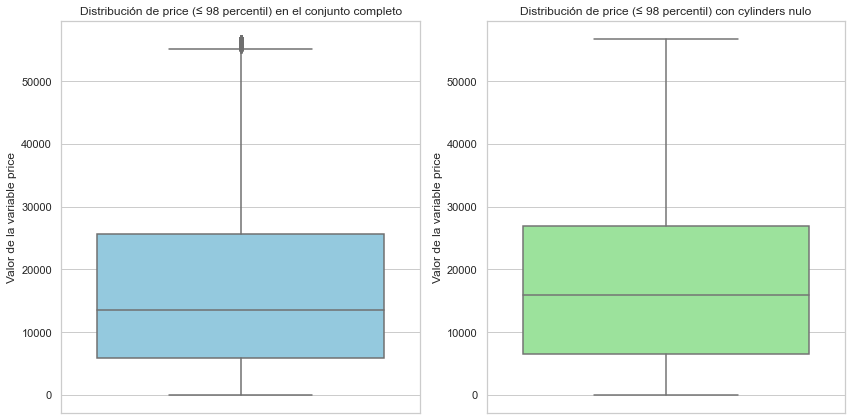

In [18]:
# Configuración para gráficos
sns.set(style="whitegrid")  # Estilo de gráficos

# Calcular el percentil de la variable objetivo 'price'
p = 98
percentile = df['price'].quantile(p/100)

# Filtrar los datos: registros donde 'price' <= percentil
df_percentile = df[df['price'] <= percentile]

# Filtrar datos donde 'condition' es nulo y 'price' <= percentil
df_null_X = df_percentile[df_percentile['cylinders'].isnull()]

# Crear los boxplots
plt.figure(figsize=(12, 6))  # Tamaño del gráfico

# Primer Boxplot: Todo el conjunto de datos
plt.subplot(1, 2, 1)
sns.boxplot(y='price', data=df_percentile, color="skyblue")
plt.title(f"Distribución de price (≤ {p} percentil) en el conjunto completo")
plt.ylabel("Valor de la variable price")

# Segundo Boxplot: Registros donde condition es nulo
plt.subplot(1, 2, 2)
sns.boxplot(y='price', data=df_null_X, color="lightgreen")
plt.title(f"Distribución de price (≤ {p} percentil) con cylinders nulo")
plt.ylabel("Valor de la variable price")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

En este caso, la situación es parecida, prácticamente tenemos los mismos boxplots en ambas situaciones, por lo que los nulos de ***cylinders*** no parecen tener un patrón en ***price***. Como esta variable estaba moderadamente relacionada con la variable ***drive***, pero esa variable tiene un volumen altísimo tambien de valores faltantes, vamos a tratar de calcular cuántos valores nulos de ***cylinders*** tienen valor en la otra variable por ver si tendría sentido una imputación a partir de ***drive***. 

In [19]:
# Crear la tabla de contingencia sin modificar el dataframe original
contingency_table = pd.crosstab(data['cylinders'].isnull(), data['drive'].isnull(),
                                rownames=['cylinders_is_null'], colnames=['drive_is_null'])

# Mostrar la tabla de contingencia
contingency_table

drive_is_null,False,True
cylinders_is_null,,
False,213850,35352
True,82463,95215


Al analizar la matriz, vemos que de los 177.678 valores nulos de nuestra variable ***cylinders***, algo menos de la mitad tienen valor en la variable ***drive***. Esto significa que por imputación solo podremos recuperar como mucho 82.463 valores. Los 95.215 seguirá siendo necesario emplear alguna técnica. LLegados a este punto, una opción interesante sería imputar los valores nulos de esta variable a la categoría modal (moda). Es cierto que esto va a cambiar la distribución de esta variable ya que había 3 categorías con más o menos la misma frecuencia que aglutinaban el 98% de los registros. Con esta imputación a la moda, seguramente cambie la distribución ya que la categoría modal que ahora representa un 38% va a pasar a representar el doble o quizá más. Otra opción es **imputar mediante un algoritmo tipo modas condicionadas a partir de la variable** ***drive*** **habiendo imputado previamente los 95.215 valores nulos de esta variable mediante su relación con la variable** ***manufacturer***.

Cambiamos de tercios y vamos a ver que hacemos con aquellas que tienen pocos nulos (porcentualmente hablando). Vamos a centrar el estudio en aquellas variables que sabemos que tienen una relación aparentemente importante con la variable objetivo: ***year*** y ***odometer*** por el lado de las variables numéricas, y ***title_status*** por el lado de las categóricas. Estas variables tienen un volumen de valores nulos muy bajito (menos del 2%), lo que supone entre los 1.000 y 7.000 registros aprox. Estas variables, dada su relevancia de cara a predecir nuestra variable objetivo, conviene no estropear mucho su distribución o sesgar los valores.

Para ***title_status***, si nos fijamos en el grueso de los valores, el 93% de los registros se encuentran en la categoría *clean*, por lo que una **imputación de los nulos a la categoría modal**, no solo no distorsionaría la distribución , si no que además evitaríamos perder información de otras variables por eliminar sus registros vacíos.

***odometer*** y ***year*** han de tratarse de forma diferente puesto que sus valores son numéricos. En su momento vimos que no eran distribuciones simetricas. En este sentido se podría hacer una **imputación de sus valores nulos con la mediana**. Entendemos que la mediana es un valor más certero ya que la media se ve más comprometida por los outliers.

Para la variable ***transmission***, es una variable que vamos a usar para inputar mediante algoritmo los valores de **condition**. Son muy pocos los registros que faltan (~1.700). Además, de entre sus categorías, la categoría *automatic* se lleva el 77% de los registros de esta variable y junto con la catagoría *manual* se llevan el 83%. Teniendo en cuenta que ambas categorías tienen una distribución de la variable objetivo casi igual, tiene sentido que **imputemos los valores nulos a la categoría modal** ***automatic***.

Por otro lado tenemos la variable ***fuel***, esta variable tiene cierto grado de relación con el fabricante (***manufacturer***). En este caso, los poquitos valores nulos podrían **imputarse mediante un algoritmo basado en modas**.

Vamos ahora con el resto de variables con valores nulos. Nos queda una variable importante: ***manufacturer*** que además de tener cierta relación con la variable objetivo, la vamos a emplear para imputar valores en las variables ***fuel*** y ***drive*** por lo que habrá que hacer algo con sus propios valores nulos. Esta variable, por lógica, tiene que tener cierta relación con la variable ***model*** ya que por lo general, los modelos de los vehículos son marcas comerciales que le dan los fabricantes a sus vehículos y muchas veces en función de sus caracteristicas. Tiene sentido evaluar la relación entre ambas y, en caso de que sea fuerte esta relación, utilizar ***model*** que tiene muy pocos nulos, para imputar los de ***manufacturer***.

In [20]:
# calculamos la tabla de contingencia entre manufacturer y model
contingency_table = pd.crosstab(df['manufacturer'], df['model'])

# calculamos su V de Cramer para ver la relación entre ambas
value = cramers_v(contingency_table)
value

0.9872664621669451

Como era de esperar, el coeficiente V de Cramer es el más alto de los vistos hasta ahora, es decir, que hacer uso de la variable ***model*** para **imputar los valores de** ***manufacturer*** **parece una buena estrategia**.

Una vez que hemos resuelto el problema de los nulos de ***manufacturer***, podemos utilizar esta variable para **imputar por modas condicionadas, los nulos de la variable** ***fuel*** **y también** ***drive***. Ambas tienen alta relación según la V de Cramer, especialmente ***drive*** con un valor de 0.46.

Nos quedaría ***type***, que es una variable con muchos valores nulos y una fuerte relación con la variable ***drive***, por lo que tras haber imputado los valores de ***drive*** podemos hacer uso de esta variable para **imputar los de** ***type***. Además esta variable tiene bastante repartidos los registros entre sus categorías por lo que se desvirtuaría mucho si imputamos a la categoría modal. Y eliminar registros no tiene sentido dado el alto volumen (~21%) de datos que habría que eliminar.

Nos queda la variable ***paint_color***, que en este caso, dado que no tiene relación alguna con ninguna otra variable ya que en la matriz de Cramer todos los valores estan casi en 0, y teniendo en cuenta que tiene un volumen muy alto de registros y muy distribuidos entre sus categorías, parece que lo más razonable sería hacer una **imputación aleatoria ponderada por frecuencia**. De este modo, esta asignación aleatoria de algún modo sería proporcional al tamaño de las categorías manteniendo la distribución intacta. No parece una variable con una gran relevancia para la objetivo, pero si que algo puede que tenga y no deberíamos descartarla a pesar del alto volumen de nulos.

Por último, la variable ***model*** que es una variable que utilizamos para imputar ***manufacturer*** y a su vez con esta otras, tiene unos cuantos registros (3.800) con valor nulo. En este caso, como habíamos pensado en un principio prescindir de esta variable y añadirla en la fase de modelado en caso de que fuera necesario, no será necesario hacer ningún procesado con ella para lidiar con los nulos. **Simplemente la dejamos fuera del dataset** en el banquillo por si fuera necesaria más adelante.


#### 1.5 Analisis de outliers en variables numéricas

A continuación, pasamos a realizar el analisis de ouliers de las variables numéricas. Analizaremos las 3 variables numericas que tenemos incluyendo la objetivo. Empezamos tratando de mostrar gráficamente los outliers de las 3 en histogramas que nos muestren como están distribuidos. Para detectarlos, primero hemos de establecer un criterio. Nosotros vamos a analizarlos utilizando 2 criterios y ver las diferencias entre ambos a qué conclusiones nos llevan. El primer criterio va a ser utilizar la métrica Z-Score (k desviaciones estandar de la media).

Umbral inferior: -36137602.80070148
Umbral superior: 36279647.41433374


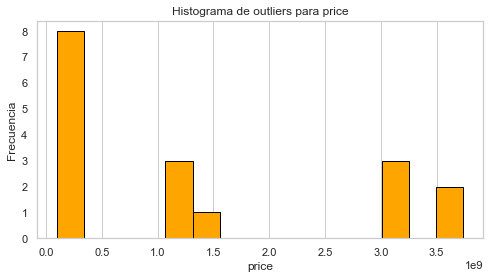

<ipython-input-21-233c03e9075f>:5: RuntimeWarning: invalid value encountered in greater
  outlier_indices = np.where(z_scores > 3)[0]


Umbral inferior: 1983.6193623217373
Umbral superior: 2039.0331809988193


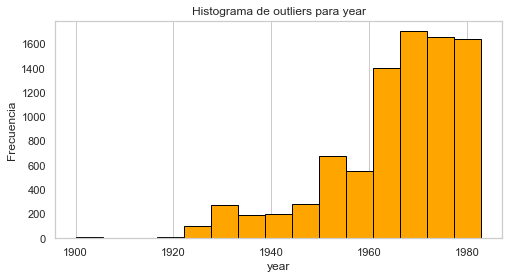

Umbral inferior: -516531.77062241174
Umbral superior: 711276.9280563046


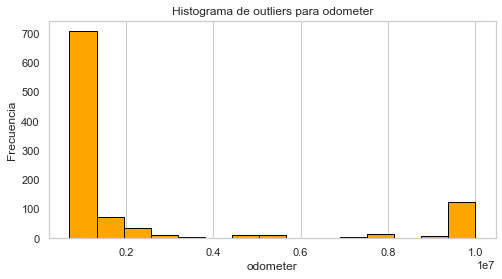


Outliers identificados:
   Variable Outliers
0     price       17
1      year     8711
2  odometer     1012


In [21]:
# Identificación de outliers (Z-score)
outliers = pd.DataFrame(columns=['Variable', 'Outliers'])
for i, column in enumerate(numeric_columns):
    z_scores = np.abs(stats.zscore(df[column], nan_policy='omit'))
    outlier_indices = np.where(z_scores > 3)[0]
    
    # Calculamos la media y la desviación estándar
    mu = np.mean(df[column])
    sigma = np.std(df[column])
    
    # Calculamos los valores correspondientes a un Z-score de 3 y -3
    upper_bound = 3 * sigma + mu
    lower_bound = -3 * sigma + mu
    print(f"Umbral inferior: {lower_bound}")
    print(f"Umbral superior: {upper_bound}")
    
    if len(outlier_indices) > 0:
        outliers = outliers.append({'Variable': column, 'Outliers': len(outlier_indices)}, ignore_index=True)
        
    # Pintar histograma de los valores outliers
        plt.figure(figsize=(8, 4))
        plt.hist(df[column].iloc[outlier_indices], bins=15, color='orange', edgecolor='black')
        plt.title(f'Histograma de outliers para {column}')
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

print("\nOutliers identificados:")
print(outliers)

Con el criterio Z-Score, hemos obtenido 17 outliers en la variable ***price*** correspondientes a los valores de precio superiores a los 36.279.647`$`. Para la variable ***year*** ha encontrado 8.711 outliers situados todos ellos por debajo del año 1984. Por último, en la variable ***odometer*** hemos detectado 1.012 correspondientes a vehículos con más de 711.276 km.

De primeras parece que la detección de estos outliers es, para la variable ***year*** un tanto exigente, ya que puede haber coches antiguos que traten de venderse de segunda mano, y sin embargo, para las otras 2 variables, parecen umbrales un poco laxos. Es decir, que seguramente estemos dejando escapar algunos outliers por debajo de esos umbrales ya que 36 millones parece una cifra un poco exagerada para el precio y 700.000 km también.

Vamos a probar con el segundo criterio que consiste en evaluar outliers en base al IQR.

Q1 (25 percentil): 5990.0
Q3 (75 percentil): 26590.0
Rango IQR: 20600.0
Umbral inferior: -24910.0
Umbral superior: 57490.0


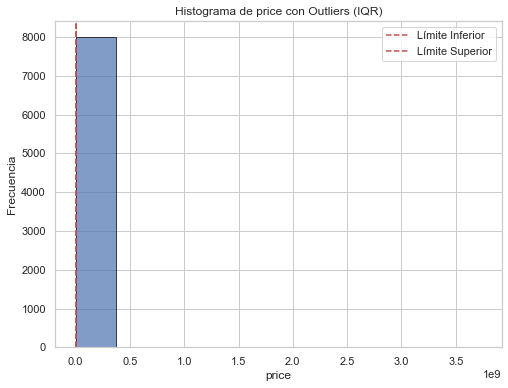

Q1 (25 percentil): 2008.0
Q3 (75 percentil): 2017.0
Rango IQR: 9.0
Umbral inferior: 1994.5
Umbral superior: 2030.5


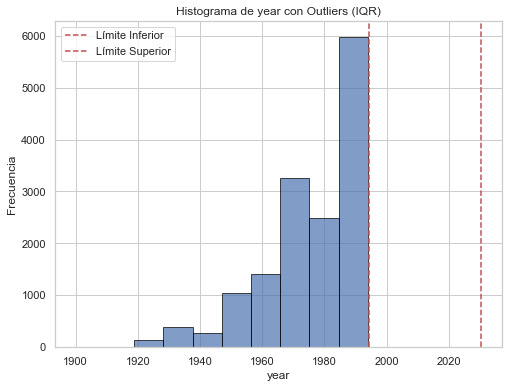

Q1 (25 percentil): 37734.0
Q3 (75 percentil): 133383.0
Rango IQR: 95649.0
Umbral inferior: -105739.5
Umbral superior: 276856.5


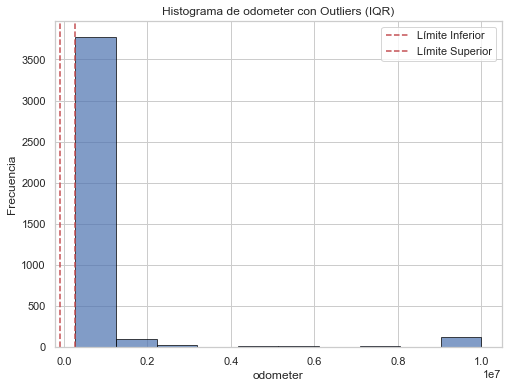


Outliers identificados mediante IQR:
   Variable Outliers
0     price     8018
1      year    15051
2  odometer     4094


In [22]:
# Identificación de outliers mediante el rango IQR
outliers = pd.DataFrame(columns=['Variable', 'Outliers'])
for i, column in enumerate(numeric_columns):
    df_col_dropna = df[column].dropna()
    Q1 = df_col_dropna.quantile(0.25)  # Primer cuartil
    Q3 = df_col_dropna.quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartílico
    
    # Limites para outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificar los outliers
    outliers_values = df_col_dropna[(df_col_dropna < lower_bound) | (df_col_dropna > upper_bound)]
    if len(outliers_values) > 0:
        outliers = outliers.append({'Variable': column, 'Outliers': len(outliers_values)}, ignore_index=True)
 
        print(f"Q1 (25 percentil): {Q1}")    
        print(f"Q3 (75 percentil): {Q3}")
        print(f"Rango IQR: {IQR}")
        print(f"Umbral inferior: {lower_bound}")
        print(f"Umbral superior: {upper_bound}")

        # Graficar los histogramas de los outliers
        plt.figure(figsize=(8, 6))
        plt.hist(outliers_values, bins=10, edgecolor='black', alpha=0.7)
        plt.axvline(lower_bound, color='r', linestyle='--', label='Límite Inferior')
        plt.axvline(upper_bound, color='r', linestyle='--', label='Límite Superior')
        plt.title(f"Histograma de {column} con Outliers (IQR)")
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.show()
    

# Mostrar los resultados de los outliers
print("\nOutliers identificados mediante IQR:")
print(outliers)

Con este nuevo criterio los umbrales de detección de outliers son bastante más exigentes. Para ***year*** ya lo era demasiado el anterior criterio, asique este, estableciendo el umbral inferior en el año 1994, es muy restrictivo. Para las otras 2, si bien es cierto que son más adecuados, parece que nos hemos pasado un poco ya que por ejemplo, un umbral superior de 57.490`$` parece demasiado justo puesto que muchos coches tendrán precios un poco por encima. Lo mismo para los km, 276.856km no es una cifra tan descabellada para coches de segunda mano, parece un valor hsta cierto punto habitual en ventas de este tipo. Estos umbrales estrictos son los que han subido de 17 a 8.018 el número de outliers en ***price*** y de 1.012 a 4.094 en ***odometer***.

Seguramente aplicando a unas un criterio y a otras otro, encontraremos un punto intermedio. Además, tenemos la posibilidad de ajustar el criterio si lo consideramos adecuado modificando el valor del algoritmo que determina las condiciones (Z-Score en uno y k veces IQR en el otro). 

Por lo pronto el criterio de Z-Score, parece más adecuado para una variable como ***years*** donde la media, a pesar de ser una distribución asimétrica, no está tan alejada de la mediana donde se desvirtúan mucho los umbrales. Si nos parece muy restrictivo para esta variable podemos probar aumentando a 4 el z-score permitido.

Umbral inferior: 1974.3837258755568
Umbral superior: 2048.2688174449995
Outliers identificados: 6387


<ipython-input-23-5ff8b55d0f02>:2: RuntimeWarning: invalid value encountered in greater
  outlier_indices = np.where(z_scores > 4)[0]


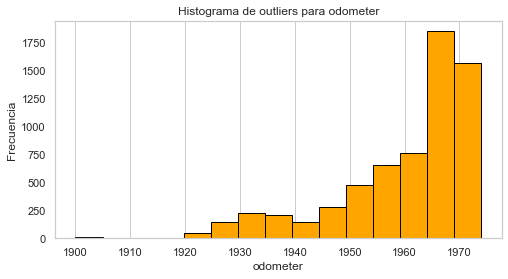

In [23]:
z_scores = np.abs(stats.zscore(df['year'], nan_policy='omit'))
outlier_indices = np.where(z_scores > 4)[0]
    
# Calculamos la media y la desviación estándar
mu = np.mean(df['year'])
sigma = np.std(df['year'])
    
# Calculamos los valores correspondientes a un Z-score de 3 y -3
upper_bound = 4 * sigma + mu
lower_bound = -4 * sigma + mu
print(f"Umbral inferior: {lower_bound}")
print(f"Umbral superior: {upper_bound}")
print(f"Outliers identificados: {len(outlier_indices)}")
    
if len(outlier_indices) > 0:
    outliers = outliers.append({'Variable': column, 'Outliers': len(outlier_indices)}, ignore_index=True)
        
# Pintar histograma de los valores outliers
    plt.figure(figsize=(8, 4))
    plt.hist(df['year'].iloc[outlier_indices], bins=15, color='orange', edgecolor='black')
    plt.title(f'Histograma de outliers para {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Para las otras 2 variables, vamos a utilizar el criterio del rango IQR ya que es menos sensible a la media cuando esta está muy alejada por culpa de los outliers desorbitados. En ambos casos, vamos a probar con 3 veces el IQR en lugar de 1.5 veces para permitir algunos valores adicionales.

Q1 (25 percentil): 5990.0
Q3 (75 percentil): 26590.0
Rango IQR: 20600.0
Umbral inferior: -55810.0
Umbral superior: 88390.0


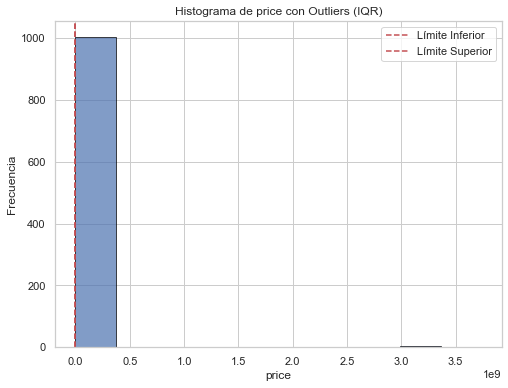

Q1 (25 percentil): 37734.0
Q3 (75 percentil): 133383.0
Rango IQR: 95649.0
Umbral inferior: -249213.0
Umbral superior: 420330.0


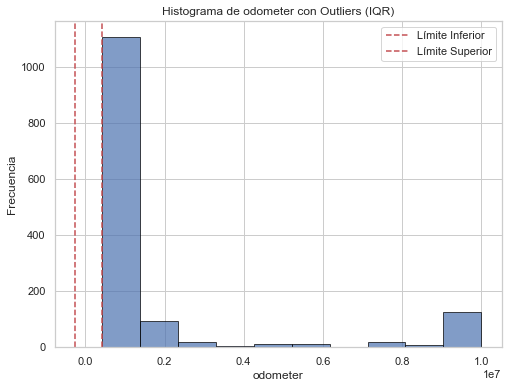


Outliers identificados mediante IQR:
   Variable Outliers
0     price     1013
1  odometer     1405


In [24]:
# Identificación de outliers mediante el rango IQR
outliers = pd.DataFrame(columns=['Variable', 'Outliers'])
for i, column in enumerate(['price','odometer']):
    df_col_dropna = df[column].dropna()
    Q1 = df_col_dropna.quantile(0.25)  # Primer cuartil
    Q3 = df_col_dropna.quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartílico
    
    # Limites para outliers
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Identificar los outliers
    outliers_values = df_col_dropna[(df_col_dropna < lower_bound) | (df_col_dropna > upper_bound)]
    if len(outliers_values) > 0:
        outliers = outliers.append({'Variable': column, 'Outliers': len(outliers_values)}, ignore_index=True)
 
        print(f"Q1 (25 percentil): {Q1}")    
        print(f"Q3 (75 percentil): {Q3}")
        print(f"Rango IQR: {IQR}")
        print(f"Umbral inferior: {lower_bound}")
        print(f"Umbral superior: {upper_bound}")

        # Graficar los histogramas de los outliers
        plt.figure(figsize=(8, 6))
        plt.hist(outliers_values, bins=10, edgecolor='black', alpha=0.7)
        plt.axvline(lower_bound, color='r', linestyle='--', label='Límite Inferior')
        plt.axvline(upper_bound, color='r', linestyle='--', label='Límite Superior')
        plt.title(f"Histograma de {column} con Outliers (IQR)")
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.show()
    

# Mostrar los resultados de los outliers
print("\nOutliers identificados mediante IQR:")
print(outliers)

Para la variable ***odometer*** hemos llegado a un valor con el que nos encontramos cómodos de 420.330 km. Es una cifra bastante alta que no nos hace perder valores elevados y sin embargo marcamos como outliers 1.405 valores todavía muy por encima de esa cifra.

En el caso de ***price***, con este criterio, hemos marcado 1.013 valores cuyo precio es superior a 88.390`$`, es cierto que podríamos subir un poco más este umbral, pero tampoco parece irracional. Hablamos de coches de segunda mano y sus precios no suelen ser mucho más elevados.

Ahora nos toca decidir cuales osn las opciones que planteamos a raíz de estos resultados de outliers. Se podrían transformar por los valores de los umbrales que hemos escogido y así no perderíamos sus registros. Otra opción sería hacer algún tipo de imputación de a uno sustituyendo sus valores con algún criterio, pero esta opción parece más compleja dado que aunque no son muchos, ir de a uno con pocos miles, parece muy laborioso. **Vamos a optar por la opción de eliminar los outliers de las variables** ***price*** y ***odometer*** que al final son muy pocos respecto del total de registros con que contamos.

En cuanto a la variable ***year***, para no eliminar 6.390 registros, lo que vamos a hacer es **transformar sus valores por el valor del umbral** que hemos escogido en el criterio para detectarlos. Esto hará que la distribución cambie ligeramente en el umbral inferior, pero respecto del total de los datos, esperamos que no cambie practicamente la distribución. Además, al eliminar los outliers de las otras 2, es posible que se eliminen registros de entre los outliers de esta.

### 2. Data Preparation

Una vez que hemos llevado a cabo el analisis de **Data Understanding**, disponemos de un conocimiento muy extenso acerca de los datos y de las distintas relaciones entre las variables. También conocemos los problemas de calidad asociados al conjunto.

En base a todo ese conocimiento adquirido, hemos ido elaborando una serie de conclusiones que nos van a permitir tomar decisiones y preparar los datos en esta fase de **Data Preparation**. Su finalidad es esa, preparar los datos para que puedan ser utilizados en la fase posterior de modelado sin preocuparse del conjunto de datos en si.

Empezamos esta fase importando las librerías y cargando de nuevo los datos originales y a partir de ellos, ir preparando todo.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from sklearn.metrics import mutual_info_score
from scipy.stats import chi2_contingency
from itertools import combinations

# Cargar el dataset desde el archivo CSV
data = pd.read_csv('vehicles_red.csv')

#### 2.1 Selección de variables

El primer paso en la limpieza de los datos va a ser la selección de variables. Vamos a eliminar del conjunto todas las variables que no sean relevantes o que hayamos decidido que no serán utilizadas por ciertos motivos.

Empezamos eliminando la variable ***county*** que no tenía ningún valor distinto de nulo. Eliminaremos también las variables ***lat*** y ***long*** ya que parecía una información poco útil para el proyecto de predicción de las ventas de vehículos usados y más cuando vamos a mantener otras variables como la región que seguramente capturarán parte de la posible información que pueda aportar. Descartamos también variables como ***id*** o ***VIN*** que son meros identificadores unívocos que no aportan nada relevante, y la variable **posting_date** que es la fecha de publicación del anuncio en los últimos 30 días.

Por otro lado, del estudio de los datos, concluimos que debíamos desechar la variable ***size*** por tener un porcentaje en torno al 71% de valores faltantes. Demasiados como para mantener la variable e imputarlos.

Por último, vamos a prescindir de la variable ***region***, ya que contamos con la variable ***state*** que para este caso, asumimos que no aporta gran información.

Mantenemos por el momento la variable ***model*** ya que la utilizaremos más adelante para la imputación de valores nulos.

In [26]:
# Elimnar columnas irelevantes persistiendo el cambio en el dataframe original
data.drop(columns=['county','lat','long','id','VIN','size','region','posting_date'], inplace=True)

#### 2.2 Selección de registros

Procedemos ahora con la selección de registros. Por lo general tratamos de mantener el mayor número posible de registros para mantener cuanta más información mejor. 

En este sentido, vamos a descartar algunos registros relacionados en primera instancia con valores faltantes. Entre todos los registros, algunos cuentan con valores en todas las variables, otros tienen una variable con valor nulo, otras tienen más de una. Aquellos registros que tengan un númeor elevado de variables con valor nulo, consideramos apropiado eliminarlos del conjunto puesto que no se dispone de la información suficiente en las variables que puedan ayudar en la predicción, o que por el hecho de no contar con información para poder imputar valores adecuadamente, se puede incurrir en problemas para el modelo.

Eliminamos todos los registros con 6 o más variables nulas:

In [27]:
# Elimnar registros con 6 o más valores nulos persistiendo el cambio en el dataframe original
data.dropna(thresh=data.shape[1] - 5, inplace=True)

Siguiendo con la selección de registros en base a los valores nulos, vamos a eliminar aquellos registros que tengan valor nulo en las variables ***model*** y ***manufacturer***. Hacemos esto porque si ambas variables son nulas, no podremos imputar valores de la variable ***manufacturer*** a través de la variable ***model*** por no tener valor tampoco. En el resto de casos, o tenemos ya el valor de ***manufacturer*** que es el que nos interesa, o disponemos de valor en ***model*** que nos llevará a imputar valores en los nulos de ***manufacturer***.

In [28]:
# Eliminar registros donde ambas variables sean nulas
data = data[~(data[['model', 'manufacturer']].isnull().sum(axis=1) == 2)]

Más adelante vamos a imputar valores nulos de ***manufacturer*** según los valores de ***model*** tomando la moda de cada categoría de la variable ***model***. Para ello, eliminaremos previamente aquellos registros nulos de la variable ***manufacturer*** correspondientes a modelos para los que todos sus registros tienen vacío el campo ***manufacturer*** y que por tanto no tendrán valor modal para dicha categoría de ***model***. Se podría intentar imputar de otra forma, en lugar de eliminarlos, pero hemos optado por quitarlos del dataset al no ser muchos registros. Los que queden nulos en ***manufacturer*** los imputaremos más adelante.

In [29]:
# Agrupar por 'model' y comprobar si todos los valores de 'manufacturer' son nulos
models_with_all_nulls = data.groupby('model')['manufacturer'].apply(lambda x: x.isnull().all())

# Filtrar los modelos donde 'manufacturer' es completamente nulo
models_all_null_list  = models_with_all_nulls[models_with_all_nulls].index.tolist()

# Eliminamos los registros con valores vacíos en Manufacturer que se encuentren en el listado de modelos anterior
data = data[~((data['manufacturer'].isnull()) & (data['model'].isin(models_all_null_list)))]

Ahora pasamos a realizar la selección de registros según las conclusiones de outliers que hemos obtenido.

Cuando analizamos esta parte, determinamos que lo mejor sería eliminar los outliers detectados en las variables ***price*** y ***odometer*** por ser muy pocos y seguramente corresponderse con errores o inconsistencias en los datos recogidos. Los outliers en estas 2 variables los habíamos detectado mediante el criterio de valores fuera de 3 veces el rango IQR. En este caso, los valores nulos serían también eliminados por considerarse como outliers. Por lo que vamos a trabajar los valores nulos antes para no perder la información de sus registros.

En el caso de la variable ***price*** no tiene ningún valor nulo, sin embargo ***odometer*** si que tiene algunos. Para esta variable vamos a imputar sus valores nulos con la mediana ya que tiene una distribución muy asimétrica y la mediana es un valor más apropiado.

In [30]:
# Calcula la mediana de la variable 'odometer'
mediana = data['odometer'].median()

# Reemplaza los valores nulos con la mediana
data['odometer'].fillna(mediana, inplace=True)

Una vez imputados los valores nulos de la variable ***odometer***, podemos proceder a eliminar los registros de outliers asociados a las variables ***odometer*** y ***price***.

In [31]:
# Calcular el IQR para cada variable
Q1_odo = data['odometer'].quantile(0.25)
Q3_odo = data['odometer'].quantile(0.75)
IQR_odo = Q3_odo - Q1_odo

Q1_price = data['price'].quantile(0.25)
Q3_price = data['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# Calcular los límites inferior y superior
lower_limit_odo = Q1_odo - 3 * IQR_odo
upper_limit_odo = Q3_odo + 3 * IQR_odo

lower_limit_price = Q1_price - 3 * IQR_price
upper_limit_price = Q3_price + 3 * IQR_price

# Filtrar los registros que están dentro de los límites para ambas variables
data = data[(data['odometer'] >= lower_limit_odo) & (data['odometer'] <= upper_limit_odo) &
                 (data['price'] >= lower_limit_price) & (data['price'] <= upper_limit_price)]

Ya hemos eliminado los registros asociados a outliers en los que habíamos tomado esa determinación. Con ello terminamos la parte de selección de variables y registros. 


#### 2.3 Tratamiento de valores nulos

Ahora vamos a trabajar más en detalle los valores nulos. Hasta ahora hemos trabajado en cierto modo en esta parte ya que en la selección de registros se han tratado algunos nulos. Ahora vamos a aplicar las decisiones que habíamos tomado a partir del analisis anterior respecto de cada una de las variables que aún tienen valores nulos.

Comenzamos con la variable ***years*** para dejar terminadas las variables numéricas sin valores nulos. Para esta variable habíamos determinado que imputaríamos los nulos al valor de la mediana igual que hicimos con ***odometer***.


In [32]:
# Calcula la mediana de la variable 'year'
mediana = data['year'].median()

# Reemplaza los valores nulos con la mediana
data['year'].fillna(mediana, inplace=True)

Seguimos con la variable ***manufacturer*** que hemos de imputar sus valores a partir de ***model***. Vamos a hacer una imputación utilizando como referencia ***model*** y tomando la moda de cada categoría de la variable ***model***. Es decir, tomamos todas las combinaciones que se encuentren en el dataset donde ***model*** sea de una categoría y la variable ***manufacturer*** sea de las categorías que tenga que ser. En este sentido la categoría modal de ***manufacturer*** será la categoría a la que asignaremos el valor nulo cuando ***model*** sea esa categoría de referencia. Asi con todas las categorías de ***model***.

Creamos una función que me permita imputar valores nulos según la moda de las categorías agrupadas de otra variable:

In [33]:
def impute_missing_with_mode(df, group_var, target_var):
    
    # Calcular la moda de target_var para cada valor de group_var
    mode_per_group = df.groupby(group_var)[target_var].agg(
        lambda x: x.mode()[0] if not x.mode().empty else None
    )

    # Función auxiliar para imputar
    def impute_value(row):
        if pd.isnull(row[target_var]):
            return mode_per_group[row[group_var]]
        return row[target_var]
    
    # Retornar la columna imputada
    return df.apply(impute_value, axis=1)

In [34]:
# Imputar 'manufacturer' usando 'model' como variable de agrupación
data['manufacturer'] = impute_missing_with_mode(data, group_var='model', target_var='manufacturer')

# Eliminar la variable 'model' del conjunto de datos puesto que ya no se va a utilizar mas en esta fase
data.drop(columns=['model'],inplace=True)

Ahora que tenemos resueltos los valores nulos de ***manufacturer*** podemos utilizar esta variable para imputar los valores nulos de ***fuel*** y ***drive***. Empezamos con ***fuel*** y para ello vamos a imputar mediante modas condicionales como hicimos en el caso de ***manufacturer***.

In [35]:
# Imputar 'fuel' usando 'manufacturer' como variable de agrupación
data['fuel'] = impute_missing_with_mode(data, group_var='manufacturer', target_var='fuel')

Vamos ahora con ***drive*** a través de la variable ***manufacturer*** de nuevo. Aplicamos el mismo tipo de imputación modal para según qué fabricante sea.

In [36]:
# Imputar 'drive' usando 'manufacturer' como variable de agrupación
data['drive'] = impute_missing_with_mode(data, group_var='manufacturer', target_var='drive')

Seguimos con la imputación de valores nulos. Esta vez vamos con las variables ***type*** y ***cylinder*** a partir de ***drive***. Ambas tienen una relación estrecha según V de Cramer con la variable ***drive*** por lo que imputaremos por modas condicionadas a las categorías de esa variable al igual que en los casos anteriores. Es muy interesante este tipo de imputación para variables categóricas por su sencillez en la implementación y la eficacia que consigue.

In [37]:
# Imputar 'type' usando 'drive' como variable de agrupación
data['type'] = impute_missing_with_mode(data, group_var='drive', target_var='type')

# Imputar 'cylinder' usando 'drive' como variable de agrupación
data['cylinders'] = impute_missing_with_mode(data, group_var='drive', target_var='cylinders')

El siguiente paso es el tratamiento de los valores nulos de las variables ***transmission*** y ***title_status***. Ambas variables son relevantes a priori y por ello vamos a tratar los nulos. Al no tener relación con otras variables imputaremos al valor modal de cada una de ellas. Al no ser muchos valores no debería hacer cambiar la distribución sesgando los datos.

In [38]:
# Calcular la moda de la variable 'transmission'
mode_value = data['transmission'].mode()[0]

# Imputar los valores nulos con la moda
data['transmission'] = data['transmission'].fillna(mode_value)

# Calcular la moda de la variable 'title_status'
mode_value = data['title_status'].mode()[0]

# Imputar los valores nulos con la moda
data['title_status'] = data['title_status'].fillna(mode_value)

Una vez que hemos resuelto los nulos de ***transmission*** podemos proceder a utilizar esta variable para imputar los nulos de ***condition*** que son bastante masivos. Empleamos la imputación por moda condicional para ayudarnos de la variable ***transmission***.

In [39]:
# Imputar 'condition' usando 'transmission' como variable de agrupación
data['condition'] = impute_missing_with_mode(data, group_var='transmission', target_var='condition')

Y por último vamos a imputar valores nulos de la variable ***paint_color***. En este caso vamos a imputar los valores utilizando las categorías de la propia variable pero de forma aleatoria con un peso ponderado por la frecuencia de cada una.

In [40]:
# Calcular la distribución original de las categorías no nulas
category_distribution = data['paint_color'].dropna().value_counts(normalize=True)

# Función para imputar nulos respetando la distribución original
def impute_randomly(series, distribution):
    n_nulls = series.isnull().sum()
    imputed_values = np.random.choice(distribution.index, size=n_nulls, p=distribution.values)
    series.loc[series.isnull()] = imputed_values
    return series

# Aplicar la imputación
data['paint_color'] = impute_randomly(data['paint_color'], category_distribution)

D:\ut06691\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Tras esta última imputación, no tenemos más valores nulos que tratar y podemos dar por zanjado este punto.


#### 2.4 Tratamiento de outliers

El siguiente paso será tratar los outliers que no hemos tratado aún que son los de la variable ***year***. Para esta variable habíamos determinado que para no tener que eliminar tantos registros, vamos a aplicar una winsorización de los outliers detectados (aquellos por debajo del año 1974 ya que por encima del año 2022 no hay valores).

In [41]:
def winsorize_zscore(series, threshold):
    # Calcular la media y desviación estándar y z-score
    mean = series.mean()
    std_dev = series.std()
    z_scores = (series - mean) / std_dev
    
    # Definir los umbrales
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    
    # Aplicar winsorización
    series_winsorized = series.copy()
    series_winsorized = np.where(series < lower_bound, lower_bound, series_winsorized)
    series_winsorized = np.where(series > upper_bound, upper_bound, series_winsorized)
    
    return pd.Series(series_winsorized, index=series.index)

data['year'] = winsorize_zscore(data['year'], 4)

Con esto temrinamos la limpieza de outliers. 


#### 2.4 Otras transformaciones

Vamos a realizar una transformación más higienica que otra cosa, que consiste en convertir el tipo de datos de la variable ***odometer*** de float a int, por eficiencia y limpieza en el código ya que al final no hay valores decimales en esa variable.

In [42]:
# Convertir la columna 'odometer' de float a int
data['odometer'] = data['odometer'].astype(int)

Ya tenemos los datos limpios sin valores vacíos, outliers y con todos los registros y variables debidamente seleccionados. 

Ahora, pensando en un modelo de regresión lineal, debemos llevar a cabo una estandarización o normalización de las variables numéricas. Esto evitará problemas de precisión o errores en el modelo derivados de diferencias en escalas de valores muy elevadas entre las variables.

Emplearemos una estandarización mediante un escalado standar que consiste en estandarizar respecto a la media y la desviación típica. De esta forma las variables tendrán media 0 y desviación 1.

In [43]:
# Identificar las columnas numéricas
numerical_cols = data.select_dtypes(include=['number']).columns

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Estandarizar las variables numéricas
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

Por último, dado que estamos pensando en un modelo de regresión lineal, las variables categóricas no se le pueden pasar al modelo tal cual. Para ello debemos hacer algún tipo de codificación convirtiendolas en numéricas de forma que sea compatible con el modelo de regresión. Hay varios tipos de codificación que se pueden implementar, y dado que nuestras categorías no tienen una relación ordinal entre ellas, lo mejor es aplicar una codificación tipo one-hot encoding que codifica cada categoría de una variable categórica en variables independientes que solo pueden tomar como valores 1 o 0 según si la variable categórica original tenía como categoría la de esta nueva variable dummy o no.

Es fundamental para evitar colinealidad, que al crear tantas variables dummy como categorías, siempre nos dejemos una sin añadir. Es decir, crear variables dummy como categorías menos 1. 

In [44]:
# Identificar las columnas categóricas
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# Aplicar One-Hot Encoding solo a las columnas categóricas
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

Con esta transformación, la pega que tiene es que hemos aumentado la dimensionalidad de nuestro conjunto de datos pasando a tener 142 variables. No es despreciable. Es normal dado que hay variables categóricas como ***manufacturer*** o ***state*** que tienen 42 y 51 categorías distintas cada respectivamente.

Con esta última transformación hemos terminado con la fase de **Data Preparation** y nuestros datos están preparados para la fase de modelización. 


#### 2.5 Exportación de los datos

En este punto se podría llevar a cabo la separación del conjunto de datos entre datos de entrenamiento y datos de test y validación. También se puede llevar a cabo en la propia fase de modelización y así decidir en ese momento cómo se quiere realizar la división. En este caso, por no tener que exportar 2 conjuntos fijos a .csv y que sean esos los que tengamos que importar en el siguiente módulo, vamos a dejar esa operación para el próximo módulo y ahora exportamos el conjunto completo.

In [45]:
# Exportar el DataFrame a un archivo CSV en el directorio actual sin incluir la columna de índices
data.to_csv('vehicles_prep.csv', index=False)